# San Francisco Crime Prediction
### Welcome to the San Francisco crime prediction notebook, where we will be predicting the type of crime commited in San Francisco given the dates, day of the week, PD district, address and location.

In [352]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import Counter
from sodapy import Socrata
import sys

sys.path.append("..")

import src.config as config

In [122]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Firstly, we will collect the train and test data.

In [123]:
client = Socrata("data.sfgov.org",
                 config.api_key,
                 username=config.username,
                 password=config.password)

results = client.get("wg3w-h783", limit=55000, order="incident_date DESC")

In [359]:
# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'])

In [360]:
df = df[~df['incident_category'].isnull()]
df = df[~df['latitude'].isnull()]
df = df[~df['police_district'].isnull()]

In [361]:
df = df[["incident_datetime", "incident_day_of_week", "police_district", "incident_category",
#                          "latitude", "longitude"
        ]]

In [342]:
avg_district_df = df.copy()
avg_district_df["Count"] = 1
avg_district_df = avg_district_df.set_index(
    avg_district_df["incident_datetime"]).drop(columns=["incident_datetime"])

In [343]:
# avg_district_df = avg_district_df.groupby(['police_district', 'incident_category']).resample('1D').sum()
avg_district_df = avg_district_df.groupby(['police_district']).resample('1D').sum()

In [344]:
avg_district_df = avg_district_df.reset_index()

avg_district_df

,police_district,incident_datetime,Count
0,Bayview,2020-07-16,12
1,Bayview,2020-07-17,39
2,Bayview,2020-07-18,14
3,Bayview,2020-07-19,46
4,Bayview,2020-07-20,41
...,...,...,...
1974,Tenderloin,2021-01-07,23
1975,Tenderloin,2021-01-08,29
1976,Tenderloin,2021-01-09,8
1977,Tenderloin,2021-01-10,17


In [345]:
X = avg_district_df.copy()

# Feature engineering

In [346]:
X = pd.concat([X, pd.get_dummies(X["police_district"])], axis=1).drop(columns=["police_district"])
# X = pd.concat([X, pd.get_dummies(X["incident_category"])], axis=1).drop(columns=["incident_category"])

In [347]:
X['year'] = pd.to_datetime(X['incident_datetime']).dt.year
X['month'] = pd.to_datetime(X['incident_datetime']).dt.month
X['day'] = pd.to_datetime(X['incident_datetime']).dt.day

In [348]:
y = X[["Count"]]
X = X.drop(['incident_datetime', "Count"], axis=1)

# Using DT

In [349]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor()
regr_1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [350]:
def get_prediction_for_dates(model, precint, month, day, year=2021):
    testing = pd.DataFrame(columns=X.columns)
    data = pd.DataFrame({precint: [1], "year":year, "month":month, "day":day})
    testing = testing.append(data).fillna(0)
    return model.predict(testing)

In [391]:
pd_districts = ['Bayview', 'Central', 'Ingleside', 'Mission', 'Northern', 
                'Out of SF', 'Park', 'Richmond', 'Southern', 'Taraval', 
                'Tenderloin']

In [354]:
d = datetime.today() - timedelta(days=10)

In [375]:
rng = pd.date_range(d, periods=10, freq='d')
rng = pd.to_datetime(rng, format='%Y%m%d')
dates_to_query = pd.DataFrame({ 'Date': rng}) 

In [376]:
dates_to_query["year"] = dates_to_query.Date.dt.year
dates_to_query["day"] = dates_to_query.Date.dt.day
dates_to_query["month"] = dates_to_query.Date.dt.month
dates_to_query["Date"] = dates_to_query.Date.dt.date

In [381]:
predictions_dates = dates_to_query.Date.astype(str).values

In [417]:
dates_to_query

,Date,year,day,month,Bayview,Central,Ingleside,Mission,Northern,Out of SF,Park,Richmond,Southern,Taraval,Tenderloin,total_crime_rate
0,2021-01-02,2021,2,1,52.0,36.0,28.0,21.0,42.0,3.0,11.0,12.0,25.0,21.0,20.0,271.0
1,2021-01-03,2021,3,1,22.0,36.0,13.0,34.0,35.0,7.0,11.0,16.0,29.0,8.0,16.0,227.0
2,2021-01-04,2021,4,1,27.0,27.0,24.0,31.0,53.0,0.0,4.0,23.0,29.0,19.0,24.0,261.0
3,2021-01-05,2021,5,1,26.0,38.0,34.0,24.0,28.0,1.0,14.0,10.0,30.0,25.0,42.0,272.0
4,2021-01-06,2021,6,1,27.0,33.0,33.0,33.0,33.0,0.0,11.0,14.0,27.0,22.0,34.0,267.0
5,2021-01-07,2021,7,1,36.0,28.0,25.0,36.0,31.0,1.0,19.0,11.0,17.0,30.0,23.0,257.0
6,2021-01-08,2021,8,1,35.0,33.0,32.0,44.0,37.0,4.0,9.0,20.0,29.0,12.0,29.0,284.0
7,2021-01-09,2021,9,1,21.0,39.0,18.0,25.0,27.0,0.0,11.0,11.0,17.0,11.0,8.0,188.0
8,2021-01-10,2021,10,1,17.0,30.0,11.0,32.0,23.0,2.0,11.0,5.0,11.0,24.0,17.0,183.0
9,2021-01-11,2021,11,1,21.0,15.0,12.0,19.0,15.0,2.0,6.0,10.0,12.0,8.0,16.0,136.0


In [406]:
def get_prediction_for_dates_df(model, dates):
    for i in pd_districts:
        testing = pd.DataFrame(columns=X.columns)
        data = pd.DataFrame({i: 1, "year":dates.year.values, "month":dates.month.values, "day":dates.day.values})
        testing = testing.append(data).fillna(0)
        y = model.predict(testing)
        dates[i] = y
    return dates

In [407]:
dates_to_query = get_prediction_for_dates_df(regr_1, dates_to_query)

In [414]:
dates_to_query["total_crime_rate"] = dates_to_query.iloc[:, 4:].sum(axis=1)

In [416]:
dates_to_query

,Date,year,day,month,Bayview,Central,Ingleside,Mission,Northern,Out of SF,Park,Richmond,Southern,Taraval,Tenderloin,total_crime_rate
0,2021-01-02,2021,2,1,52.0,36.0,28.0,21.0,42.0,3.0,11.0,12.0,25.0,21.0,20.0,271.0
1,2021-01-03,2021,3,1,22.0,36.0,13.0,34.0,35.0,7.0,11.0,16.0,29.0,8.0,16.0,227.0
2,2021-01-04,2021,4,1,27.0,27.0,24.0,31.0,53.0,0.0,4.0,23.0,29.0,19.0,24.0,261.0
3,2021-01-05,2021,5,1,26.0,38.0,34.0,24.0,28.0,1.0,14.0,10.0,30.0,25.0,42.0,272.0
4,2021-01-06,2021,6,1,27.0,33.0,33.0,33.0,33.0,0.0,11.0,14.0,27.0,22.0,34.0,267.0
5,2021-01-07,2021,7,1,36.0,28.0,25.0,36.0,31.0,1.0,19.0,11.0,17.0,30.0,23.0,257.0
6,2021-01-08,2021,8,1,35.0,33.0,32.0,44.0,37.0,4.0,9.0,20.0,29.0,12.0,29.0,284.0
7,2021-01-09,2021,9,1,21.0,39.0,18.0,25.0,27.0,0.0,11.0,11.0,17.0,11.0,8.0,188.0
8,2021-01-10,2021,10,1,17.0,30.0,11.0,32.0,23.0,2.0,11.0,5.0,11.0,24.0,17.0,183.0
9,2021-01-11,2021,11,1,21.0,15.0,12.0,19.0,15.0,2.0,6.0,10.0,12.0,8.0,16.0,136.0


# Predicting crime with a neural network

### In order to feed the data to our model, we must first make y categorical and standardise X train and test.

In [218]:
# y = to_categorical(y)
X_train, y_train = X, y

X_train["year", "month"] = preprocessing.StandardScaler().fit_transform(X_train)
# X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, test_size=0.2)
# X_train = preprocessing.StandardScaler().fit_transform(X_train)
# X_val = prepro.StandardScaler().fit_transform(X_val)

In [221]:
X_train

,Count,Bayview,Central,Ingleside,Mission,Northern,Out of SF,Park,Richmond,Southern,Taraval,Tenderloin,year,month,day
0,1,1,0,0,0,0,0,0,0,0,0,0,2020,7,21
1,0,1,0,0,0,0,0,0,0,0,0,0,2020,7,22
2,0,1,0,0,0,0,0,0,0,0,0,0,2020,7,23
3,0,1,0,0,0,0,0,0,0,0,0,0,2020,7,24
4,2,1,0,0,0,0,0,0,0,0,0,0,2020,7,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60102,0,0,0,0,0,0,0,0,0,0,0,1,2021,1,4
60103,0,0,0,0,0,0,0,0,0,0,0,1,2021,1,5
60104,0,0,0,0,0,0,0,0,0,0,0,1,2021,1,6
60105,0,0,0,0,0,0,0,0,0,0,0,1,2021,1,7


### The last part of this notebook is to create and tune a neural network.

In [117]:
X_train.shape[0]/60

239.88333333333333

Train on 14393 samples
Epoch 1/100
13793/14393 [===========================>..] - ETA: 0s - loss: 1.9997 - accuracy: 0.3818Epoch 81/100


14213/14393 [============================>.] - ETA: 0s - loss: 1.8822 - accuracy: 0.4048

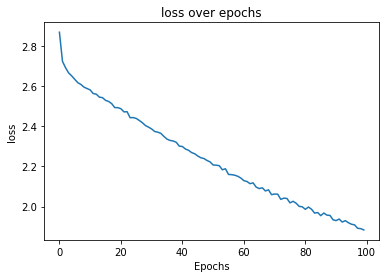

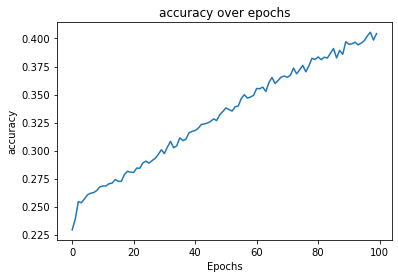

In [119]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.1))

model.add(Dense(43, activation='softmax'))
    
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')   
history = model.fit(X_train, y_train, batch_size=60, epochs=100, steps_per_epoch=239)
        
for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

Train on 14393 samples
Epoch 1/100
14213/14393 [============================>.] - ETA: 0s - loss: 1.5927 - accuracy: 0.4725Epoch 81/100


13973/14393 [============================>.] - ETA: 0s - loss: 1.5594 - accuracy: 0.4838

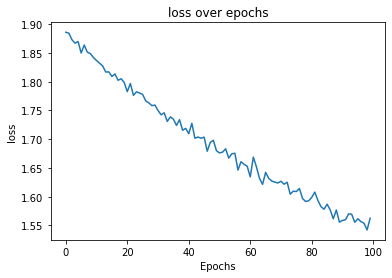

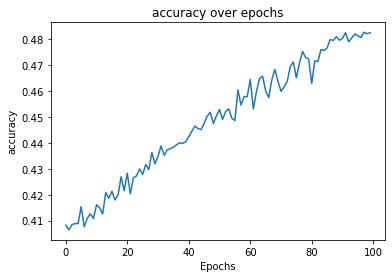

In [120]:
history = model.fit(X_train, y_train, batch_size=60, epochs=100, steps_per_epoch=239)
        
for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()